In [3]:
# DATA STANDARDIZATION

# import libraries
import os
import shutil
from collections import defaultdict 

# Directories
input_folder = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder3'
output_folder_train = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\dataSelectorAllGeometryLowerLimit\train'
output_folder_test_val = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\dataSelectorAllGeometryLowerLimit\testVal'
output_folder_test_val_disc = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\dataSelectorAllGeometryLowerLimit\testValDisc'

# Self-define parameters

# number of image in input
input_num = 4
#low limit size 
lower_limit = 7.0
#upper limit size
upper_limit = 14.0
# the size range of each bin
bin_width = 0.5
# number of size bins
num_bins = int((upper_limit-lower_limit)/bin_width)

# disrgardFactor x x_avg (average number of contours per bin) = the upper limit such that any bin with lower than this number is discarded
disregardFactor = 0.5

# propotion of data that will be used for traning given disrgardFactor x x_avg < x < x_avg x upperFactor / train_proportion
trainProportion = 0.8

# x_avg x upperFactor / train_proportion = below this number take 80% to train and above this number take x_avg x upperFactor to train
upperFactor = 2




def obtainSizeRange(targetDir, input_num, num_bins, lower_limit=7.0, upper_limit=14.0):
    lstDir = os.listdir(targetDir)    
    numLst = [i/2 + lower_limit for i in range(num_bins)]
    print(f'numLst: {numLst}')
    sizeDict = {}
    for j in numLst:
      sizeDict[j] = 0
    for i in lstDir:
        t_number = int(i.split("t-")[1].split("_")[0])
        lowerT = 200 - (200/input_num) + 1
        if lowerT <= t_number <= 200:
            size = float(i[-17:-5])
            if lower_limit < size < upper_limit:
                sizeRange = int(size*2)/2
                sizeDict[sizeRange] += 1

    # print(sizeDict)
    print(dict(sorted(sizeDict.items())))
    print(dict(sorted(sizeDict.items(), key=lambda item: item[1])))
    return dict(sorted(sizeDict.items()))

sizeDict = obtainSizeRange(targetDir = input_folder, input_num= input_num, num_bins= num_bins, lower_limit= lower_limit, upper_limit= upper_limit)
totalItems = sum(sizeDict.values())
print(totalItems)

def obtainDesiredDict(sizeDict, disregardFactor, trainProportion, upperFactor, lower_limit=7.0):
    # get avg
    print(len(sizeDict))
    numLst = [i/2 + lower_limit for i in range(len(sizeDict)+1)]

    counter = 0
    for j in numLst:
        try:
            counter += sizeDict[j]
        except KeyError:
            pass    
    x_avg = counter/(len(numLst))
    
    print(f'x_avg = {x_avg}')
    
    desiredDict = {}
    x_lower = x_avg*disregardFactor
    x_upper = (x_avg*upperFactor)/trainProportion
    
    for j in numLst:
        try:
            # x = number of contours per bin
            x = sizeDict[j]

            if x < x_lower:
                desiredDict[j] = 0
            
            elif x_lower < x < x_upper:
                desiredDict[j] = int(trainProportion*x)   
            elif x > x_upper:
                desiredDict[j] = int(x_avg*upperFactor)
                
        except KeyError:
            pass
    return desiredDict

desiredDict = obtainDesiredDict(sizeDict, disregardFactor= disregardFactor, trainProportion= trainProportion, upperFactor= upperFactor, lower_limit= lower_limit)
# print(desiredDict)

def data_standardisation(input_folder, output_folder_train, output_folder_test_val, desiredDict, input_num, bin_width, output_folder_test_val_disc, lower_limit=7.0):

   last_time_section = ((input_num-1)/(input_num))*200
   os.makedirs(output_folder_train, exist_ok=True)
   os.makedirs(output_folder_test_val, exist_ok=True)
   os.makedirs(output_folder_test_val_disc, exist_ok=True)
   
   
   # create the counter dictionary
   numLst = [i/2 + lower_limit for i in range(len(desiredDict))]
   counterDict = {}
   for j in numLst:
      counterDict[j] = 0
      

   for filename in os.listdir(input_folder):
      try:
         size = float(filename[-17:-5])
         t_number = int(filename.split("t-")[1].split("_")[0])
         if t_number > last_time_section:
            for j in numLst:
               # print(j)
               # print(size)
               if j < size < j+bin_width:
                  # print(counterDict[j])
                  # print(desiredDict[j])
                  if counterDict[j] < desiredDict[j]:
                     input_filepath = os.path.join(input_folder, filename)
                     output_filepath = os.path.join(output_folder_train, filename)
                     shutil.copy2(input_filepath, output_filepath)
                     counterDict[j] += 1
                     # print(counterDict[j])
                     for j in range(input_num-1):
                           fig_number = filename.split("_")[1]
                           t_number_new = str(int(t_number-(j+1)*(200/input_num)))
                           filename_new = [item for item in os.listdir(input_folder) if item.startswith(f"Fig_{fig_number}__t-{t_number_new}_")][0]
                           input_filepath = os.path.join(input_folder, filename_new)
                           output_filepath = os.path.join(output_folder_train, filename_new)
                           shutil.copy2(input_filepath, output_filepath)
      except (ValueError, IndexError):
         pass
   for filename2 in os.listdir(input_folder):
      if filename2 not in os.listdir(output_folder_train):
         try:
            size = float(filename2[-17:-5])
            t_number = int(filename2.split("t-")[1].split("_")[0])
            if t_number > last_time_section:
               for j in numLst:
                  if j < size < j+bin_width:
                     if desiredDict[j] < 1:
                        input_filepath = os.path.join(input_folder, filename2)
                        output_filepath = os.path.join(output_folder_test_val_disc, filename2)
                        shutil.copy2(input_filepath, output_filepath)
                        for j in range(input_num-1):
                           fig_number = filename2.split("_")[1]
                           t_number_new = str(int(t_number-(j+1)*(200/input_num)))
                           filename_new = [item for item in os.listdir(input_folder) if item.startswith(f"Fig_{fig_number}__t-{t_number_new}_")][0]
                           input_filepath = os.path.join(input_folder, filename_new)
                           output_filepath = os.path.join(output_folder_test_val_disc, filename_new)
                           shutil.copy2(input_filepath, output_filepath)
                     else:
                        input_filepath = os.path.join(input_folder, filename2)
                        output_filepath = os.path.join(output_folder_test_val, filename2)
                        shutil.copy2(input_filepath, output_filepath)
                        for j in range(input_num-1):
                           fig_number = filename2.split("_")[1]
                           t_number_new = str(int(t_number-(j+1)*(200/input_num)))
                           filename_new = [item for item in os.listdir(input_folder) if item.startswith(f"Fig_{fig_number}__t-{t_number_new}_")][0]
                           input_filepath = os.path.join(input_folder, filename_new)
                           output_filepath = os.path.join(output_folder_test_val, filename_new)
                           shutil.copy2(input_filepath, output_filepath)
         except:
            pass

   # print(counterDict)
   return counterDict
      
               

counterDict = data_standardisation(input_folder=input_folder, output_folder_train=output_folder_train, output_folder_test_val=output_folder_test_val, desiredDict=desiredDict, input_num=input_num, bin_width= bin_width, lower_limit=lower_limit, output_folder_test_val_disc=output_folder_test_val_disc)
counterDict

numLst: [7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5]
{7.0: 231, 7.5: 356, 8.0: 406, 8.5: 230, 9.0: 222, 9.5: 288, 10.0: 220, 10.5: 166, 11.0: 167, 11.5: 118, 12.0: 130, 12.5: 155, 13.0: 234, 13.5: 148}
{11.5: 118, 12.0: 130, 13.5: 148, 12.5: 155, 10.5: 166, 11.0: 167, 10.0: 220, 9.0: 222, 8.5: 230, 7.0: 231, 13.0: 234, 9.5: 288, 7.5: 356, 8.0: 406}
3071
14
x_avg = 204.73333333333332


{7.0: 184,
 7.5: 284,
 8.0: 324,
 8.5: 184,
 9.0: 177,
 9.5: 230,
 10.0: 176,
 10.5: 132,
 11.0: 133,
 11.5: 94,
 12.0: 104,
 12.5: 124,
 13.0: 187,
 13.5: 118}

numLst: [7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5]
{7.0: 12, 7.5: 71, 8.0: 39, 8.5: 54, 9.0: 90, 9.5: 56, 10.0: 65, 10.5: 26, 11.0: 22, 11.5: 18, 12.0: 19, 12.5: 39, 13.0: 105, 13.5: 75}
{7.0: 12, 11.5: 18, 12.0: 19, 11.0: 22, 10.5: 26, 8.0: 39, 12.5: 39, 8.5: 54, 9.5: 56, 10.0: 65, 7.5: 71, 13.5: 75, 9.0: 90, 13.0: 105}
691
14
x_avg = 46.06666666666667
14
x_avg = 46.06666666666667


<function matplotlib.pyplot.show(close=None, block=None)>

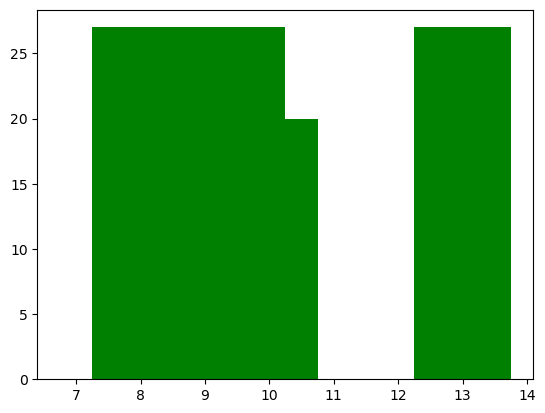

In [2]:
import matplotlib.pyplot as plt
import os
import shutil
from collections import defaultdict 

# Directories
input_folder = r'C:\Users\Public\PartIIB project 2023_2024\Image collection without reaction\00AgNO3_mole_fraction\Outputs_Grayscale_Labelled_Images_Sizes\size_folder3'
# Self-define parameters

# number of image in input
input_num = 4
#low limit size 
lower_limit = 7.0
#upper limit size
upper_limit = 14.0
# the size range of each bin
bin_width = 0.5
# number of size bins
num_bins = int((upper_limit-lower_limit)/bin_width)

# disrgardFactor x x_avg (average number of contours per bin) = the upper limit such that any bin with lower than this number is discarded
disregardFactor = 0.5

# propotion of data that will be used for traning given disrgardFactor x x_avg < x < x_avg x upperFactor / train_proportion
trainProportion = 0.8

# x_avg x upperFactor / train_proportion = below this number take 80% to train and above this number take x_avg x upperFactor to train
upperFactor = 0.6




def obtainSizeRange(targetDir, input_num, num_bins, lower_limit=7.0, upper_limit=14.0):
    lstDir = os.listdir(targetDir)    
    numLst = [i/2 + lower_limit for i in range(num_bins)]
    print(f'numLst: {numLst}')
    sizeDict = {}
    for j in numLst:
      sizeDict[j] = 0
    for i in lstDir:
        t_number = int(i.split("t-")[1].split("_")[0])
        lowerT = 200 - (200/input_num) + 1
        if lowerT <= t_number <= 200:
            size = float(i[-17:-5])
            if lower_limit < size < upper_limit:
                sizeRange = int(size*2)/2
                sizeDict[sizeRange] += 1

    # print(sizeDict)
    print(dict(sorted(sizeDict.items())))
    print(dict(sorted(sizeDict.items(), key=lambda item: item[1])))
    return dict(sorted(sizeDict.items()))

sizeDict = obtainSizeRange(targetDir = input_folder, input_num= input_num, num_bins= num_bins, lower_limit= lower_limit)
totalItems = sum(sizeDict.values())
print(totalItems)

def obtainDesiredDict(sizeDict, disregardFactor, trainProportion, upperFactor, lower_limit=7.0):
    # get avg
    print(len(sizeDict))
    numLst = [i/2 + lower_limit for i in range(len(sizeDict)+1)]

    counter = 0
    for j in numLst:
        try:
            counter += sizeDict[j]
        except KeyError:
            pass    
    x_avg = counter/(len(numLst))
    
    print(f'x_avg = {x_avg}')
    
    desiredDict = {}
    x_lower = x_avg*disregardFactor
    x_upper = (x_avg*upperFactor)/trainProportion
    
    for j in numLst:
        try:
            # x = number of contours per bin
            x = sizeDict[j]

            if x < x_lower:
                desiredDict[j] = 0
            
            elif x_lower < x < x_upper:
                desiredDict[j] = int(trainProportion*x)   
            elif x > x_upper:
                desiredDict[j] = int(x_avg*upperFactor)
                
        except KeyError:
            pass
    return desiredDict

desiredDict = obtainDesiredDict(sizeDict, disregardFactor= disregardFactor, trainProportion= trainProportion, upperFactor= upperFactor, lower_limit= lower_limit)

desiredDict = obtainDesiredDict(sizeDict, disregardFactor= disregardFactor, trainProportion= trainProportion, upperFactor= upperFactor, lower_limit= lower_limit)
plt.bar(list(desiredDict.keys()), desiredDict.values(), -0.5, color='g')
plt.show